In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict

Task 1: Exploratory analysis (5 points).

Perform EDA:
- number of users
- number of items
- number of tags
- number of ratings
- summary statistics of number of ratings per user (mean, median, quantiles)
- rating sparcity
- summary statistics of number of tags per use

### Загружаем датасеты

In [2]:
print("Downloading movielens data...")
import zipfile
import urllib.request

urllib.request.urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [3]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols

movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

### Предпроцесинг данных.Создание жанровых категорий.

In [4]:
users["user_id"] = users["user_id"].apply(lambda x: float(x))
movies["movie_id"] = movies["movie_id"].apply(lambda x: float(x))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: float(x))
ratings["user_id"] = ratings["user_id"].apply(lambda x: float(x))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [5]:
ratings['unix_timestamp'] = ratings['unix_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
ratings['unix_timestamp'].astype('datetime64[ns]')
ratings['date'] = ratings['unix_timestamp']
ratings.head()

,user_id,movie_id,rating,unix_timestamp,date
0,196.0,242.0,3.0,1997-12-04 18:55:49,1997-12-04 18:55:49
1,186.0,302.0,3.0,1998-04-04 22:22:22,1998-04-04 22:22:22
2,22.0,377.0,1.0,1997-11-07 10:18:36,1997-11-07 10:18:36
3,244.0,51.0,2.0,1997-11-27 08:02:03,1997-11-27 08:02:03
4,166.0,346.0,1.0,1998-02-02 08:33:16,1998-02-02 08:33:16


In [6]:
#Количество фильмов с установленным жанром
genre_occurences = movies[genre_cols].sum().to_dict()

In [7]:
def mark_genres(movies, genres):
    def get_random_genre(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return np.random.choice(active)
    def get_all_genres(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return '-'.join(active)
    movies['genre'] = [
        get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
    movies['all_genres'] = [
        get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

In [8]:
df = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [9]:
df.drop(['year','release_date','video_release_date','imdb_url', 'age', 'sex', 'occupation','zip_code'], inplace = True, axis = 1)

In [10]:
df.head()

,user_id,movie_id,rating,unix_timestamp,date,title,genre_unknown,Action,Adventure,Animation,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genre,all_genres
0,196.0,242.0,3.0,1997-12-04 18:55:49,1997-12-04 18:55:49,Kolya (1996),0,0,0,0,...,0,0,0,0,0,0,0,0,Comedy,Comedy
1,196.0,257.0,2.0,1997-12-04 19:06:17,1997-12-04 19:06:17,Men in Black (1997),0,1,1,0,...,0,0,0,0,1,0,0,0,Action,Action-Adventure-Comedy-Sci-Fi
2,196.0,111.0,4.0,1997-12-04 19:09:53,1997-12-04 19:09:53,"Truth About Cats & Dogs, The (1996)",0,0,0,0,...,0,0,0,1,0,0,0,0,Romance,Comedy-Romance
3,196.0,25.0,4.0,1997-12-04 19:12:35,1997-12-04 19:12:35,"Birdcage, The (1996)",0,0,0,0,...,0,0,0,0,0,0,0,0,Comedy,Comedy
4,196.0,382.0,4.0,1997-12-04 19:10:43,1997-12-04 19:10:43,"Adventures of Priscilla, Queen of the Desert, ...",0,0,0,0,...,0,0,0,0,0,0,0,0,Drama,Comedy-Drama


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 27 columns):
user_id           100000 non-null float64
movie_id          100000 non-null float64
rating            100000 non-null float64
unix_timestamp    100000 non-null object
date              100000 non-null object
title             100000 non-null object
genre_unknown     100000 non-null int64
Action            100000 non-null int64
Adventure         100000 non-null int64
Animation         100000 non-null int64
Children          100000 non-null int64
Comedy            100000 non-null int64
Crime             100000 non-null int64
Documentary       100000 non-null int64
Drama             100000 non-null int64
Fantasy           100000 non-null int64
Film-Noir         100000 non-null int64
Horror            100000 non-null int64
Musical           100000 non-null int64
Mystery           100000 non-null int64
Romance           100000 non-null int64
Sci-Fi            100000 non-null int64
T

### Проверяем на наличие пропущенных значений

In [12]:
print ("Number of movies Null values: ", movies.isnull().sum())
print ("Number of ratings Null values: ", ratings.isnull().sum())

Number of movies Null values:  movie_id                 0
title                    0
release_date             1
video_release_date    1682
imdb_url                 3
genre_unknown            0
Action                   0
Adventure                0
Animation                0
Children                 0
Comedy                   0
Crime                    0
Documentary              0
Drama                    0
Fantasy                  0
Film-Noir                0
Horror                   0
Musical                  0
Mystery                  0
Romance                  0
Sci-Fi                   0
Thriller                 0
War                      0
Western                  0
year                     0
genre                    0
all_genres               0
dtype: int64
Number of ratings Null values:  user_id           0
movie_id          0
rating            0
unix_timestamp    0
date              0
dtype: int64


In [13]:
movies.dropna(inplace=True)
print ("Number of movies Null values: ", movies.isnull().sum())

Number of movies Null values:  movie_id              0
title                 0
release_date          0
video_release_date    0
imdb_url              0
genre_unknown         0
Action                0
Adventure             0
Animation             0
Children              0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror                0
Musical               0
Mystery               0
Romance               0
Sci-Fi                0
Thriller              0
War                   0
Western               0
year                  0
genre                 0
all_genres            0
dtype: int64


### Создаем саб-сеты для визуализации

In [14]:
df[df['rating'] >= 4.5]['movie_id'].count() # Фильмы с рейтингом 4,5 или выше

21201

In [15]:
df[df['rating'] >= 4.5]['movie_id'].count() / ratings['rating'].count() # Процент фильмов с рейтингом 4,5 или выше

0.21201

In [16]:
df[df['rating'] == 5]['movie_id'].count() # Фильмы с рейтингом 5

21201

In [17]:
df[df['rating'] == 5]['movie_id'].count() / ratings['rating'].count() # Процент фильмов с рейтингом 5

0.21201

In [18]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head() # Топ фильмов по рейтингу

title
Star Wars (1977)             583
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [257]:
# количество оценок 
df_RateCount = pd.DataFrame(df.groupby('user_id', as_index = False)['rating'].agg('count')
                              .rename(columns={'rating' : 'RateCount'}))
df_RateCount.sort_values('RateCount',ascending=False).head(5)

,user_id,RateCount
404,405.0,737
654,655.0,685
12,13.0,636
449,450.0,540
275,276.0,518


In [259]:
df_RateCount['RateCount'].mean

<bound method Series.mean of 0      272
1       62
2       54
3       24
4      175
      ... 
938     49
939    107
940     22
941     79
942    168
Name: RateCount, Length: 943, dtype: int64>

In [20]:
# средняя оценка фильма
df_RateMean = pd.DataFrame(df.groupby('title', as_index = False)['rating'].agg('mean')
                              .rename(columns={'rating' : 'RateMean'}))
df_RateMean.sort_values('RateMean',ascending=False).head(5)

,title,RateMean
1472,They Made Me a Criminal (1939),5.0
944,Marlene Dietrich: Shadow and Light (1996),5.0
1273,"Saint of Fort Washington, The (1993)",5.0
1359,Someone Else's America (1995),5.0
1387,Star Kid (1997),5.0


In [21]:
# мержим саб-сеты
df_movie_rate = pd.merge(df_RateCount,df_RateMean, on='title')
df_movie_rate.sort_values('RateCount',ascending=False).head(5)

,title,RateCount,RateMean
1398,Star Wars (1977),583,4.358491
333,Contact (1997),509,3.803536
498,Fargo (1996),508,4.155512
1234,Return of the Jedi (1983),507,4.007890
860,Liar Liar (1997),485,3.156701


In [22]:
# распределение оценок по пользователям
df_distrib_of_ratings= pd.DataFrame(ratings.groupby('rating', as_index = False)['user_id'].count()
                         .rename(columns={'user_id' : 'RateCount'}))
df_distrib_of_ratings.head(10)

,rating,RateCount
0,1.0,6110
1,2.0,11370
2,3.0,27145
3,4.0,34174
4,5.0,21201


In [23]:
# the users with most ratings
users_rate = ratings[['user_id', 'movie_id']].groupby('user_id').count()
users_rate = users_rate.rename(columns={'movie_id' : 'Total'})
users_rate.sort_values('Total',ascending=False).head()

,Total
user_id,
405.0,737
655.0,685
13.0,636
450.0,540
276.0,518


In [24]:
# наиболее популярные жанры
MP_genre = df.groupby('genre', as_index = False)['user_id'].count()
MP_genre = MP_genre.rename(columns={'user_id' : 'Total ratings'})
MP_genre.sort_values('Total ratings',ascending=False).head(10)

,genre,Total ratings
7,Drama,26189
4,Comedy,18342
0,Action,11131
13,Romance,9076
15,Thriller,5820
1,Adventure,5214
14,Sci-Fi,4647
5,Crime,3505
10,Horror,3279
12,Mystery,2875


### Визуализация

In [28]:
plt.style.use('ggplot')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

#### Распределение оценок для количества фильмов (минимальное значение 50)

Text(0,0.5,'Количество фильмов')

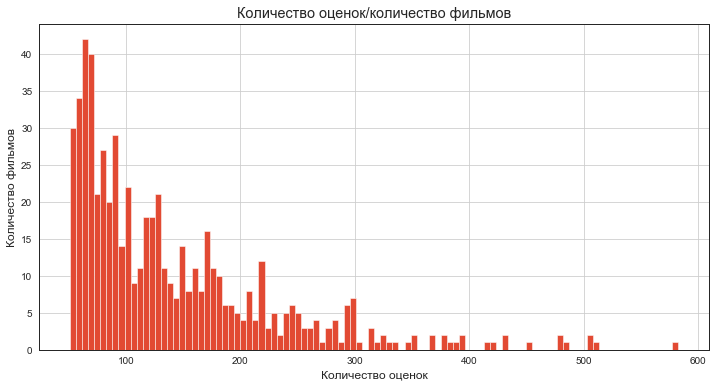

In [29]:
plt.figure(figsize=(12,6))
df_movie_rate[df_movie_rate['RateCount'] > 50]['RateCount'].hist(bins=100)
plt.title('Количество оценок/количество фильмов')
plt.xlabel('Количество оценок')
plt.ylabel('Количество фильмов')

#### Распределение шкалы оценок

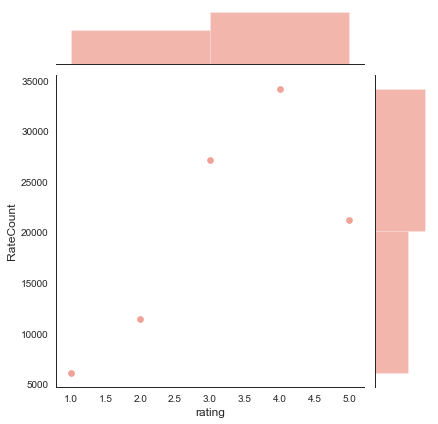

In [30]:
sns.jointplot(x='rating',y='RateCount',data=df_distrib_of_ratings,alpha=0.5)

#### Зависимость количества оценок от средней оценки

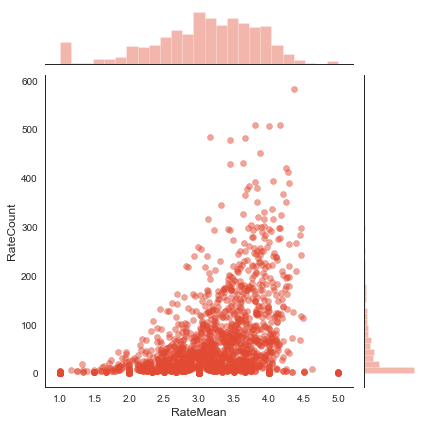

In [31]:
sns.jointplot(x='RateMean',y='RateCount',data= df_movie_rate,alpha=0.5)

#### Количество оценок пользователей

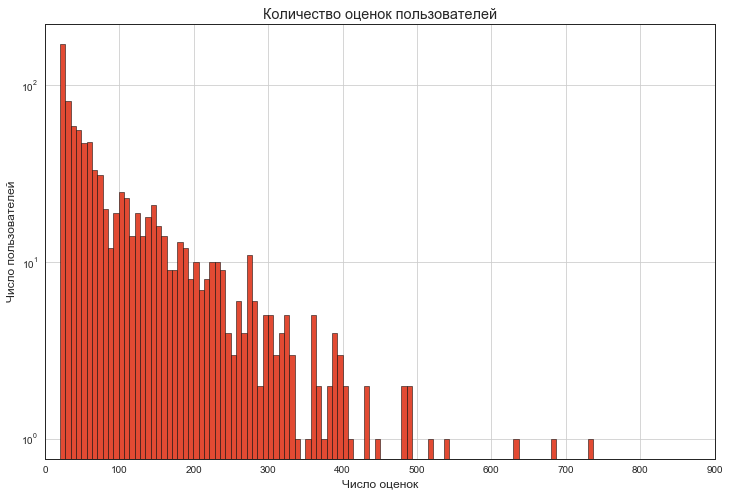

In [32]:
plt.figure(figsize=(12,8))
users_rate['Total'].hist(bins=100, edgecolor='black', log=True)
plt.title('Количество оценок пользователей')
plt.xlabel('Число оценок')
plt.ylabel('Число пользователей')
plt.xlim(0,)
plt.xticks(np.arange(0,1000,100))
plt.show()

Выводы:
1. Большая часть фильмов имеет менее 4000 оценок
2. Пик развиия киноиндустрии пришелся на начало 90-х
3. Большая часть оценок равна или больше 3
4. Большое число оценок завышает рейтинг фильма
5. Большая часть пользователей имеет диапозон от 0 до 200  оценок

### Metrics.Train/test split

Task 2: Evaluation metrics report (5 points)

Implement evaluation metrics to assess recommender performance
- MAP score
- Precision@k
- Mean percentage ranking

### Функция для деления на тест и трейн

In [25]:
def Split_DF(df, holdout_fraction=0.1):
    data =  df.sort_values(['date'])
    train = data[:(len(df.index)-int(len(df.index)*holdout_fraction))]
    test = data[(len(df.index)-int(len(df.index)*holdout_fraction)):]
    return train, test

### Метрики для оценки качества системы

In [391]:
def precision(actual, predicted, k):
    try:
        act_set = set(actual[:k])
        pred_set = set(predicted[:k])
        result = len(act_set & pred_set) / float(min(k, len(act_set)))
    except ZeroDivisionError:
        result = 0
        
    return result

def average_precision_at_k(actual, predicted, k=10):

    if len(predicted)>k:
        predicted = predicted[:k]
        
    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)    
    try:        
        result = score / float(min(k, len(actual)))
    except ZeroDivisionError:
        result = 0
    
    if len(actual)<k:
        result = score / float(min(k, len(actual)))
        
    return result

def mean_average_precision_at_k(actual, predicted, k=10):

    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


def PR(actual, predicted, k):
    
    if len(predicted)>k:
        predicted = predicted[:k]
    
    if len(actual)>k:
        actual = actual[:k] 
    
    score = 0.0
    
    for pred_values, rank in zip(predicted, range(len(predicted))):
        if pred_values in actual and pred_values in predicted:
            score += (rank+1.0) / (len(predicted))
                                  
    result = score / float(min(k, len(actual)))                             
                                 
    return score 

In [405]:
def calculate_metrics( preds, test, k):
        users =  preds['user_id'].values.tolist()
        actuals_items = []
        preds_items = []
        prec =[]
        apak = []
        percantage = []
        
        for i in users:
            actual = test[test['user_id']== i].sort_values('rating', ascending= False)['movie_id'].tolist()
            pred = preds[preds['user_id']== i]['predictions'].values[0]
            actuals_items.append(actual)
            preds_items.append(pred)
            prec.append(precision(actual,pred,k))
            apak.append(average_precision_at_k(actual,pred,k))
        
        df_metrics = pd.DataFrame({'user_id': users,
                                   'actual': actuals_items,
                                   'predictions': preds_items,
                                   'precission': prec,
                                   'ap@k': apak}, 
                                    columns = ['user_id','actual','predictions', 'precission' , 'ap@k'])
        
        for i in df_metrics['user_id'].values.tolist():
            actual = df_metrics[df_metrics['user_id']== i]['actual'].values[0]
            preds = df_metrics[df_metrics['user_id']== i]['predictions'].values[0]
            pr_rank = PR(actual,preds,k)
            percantage.append(pr_rank)
        
        df_metrics['PR']=percantage
        
        return df_metrics

In [66]:
class MPRecommender(object):
    def __init__(self, user_field='user_id', item_field='movie_id', number_of_films=10):
        self.user_field = user_field
        self.item_field = item_field
        self.number_of_films = number_of_films

    
    def fit(self, train):
        popularity_recs = train[self.item_field].value_counts().head(self.number_of_films).index.tolist()
        recs = []
        user_list = train[self.user_field].values.tolist()
        for user in user_list:
            actual = train[train[self.user_field] == user].sort_values('rating',ascending=False)[self.item_field].values
            pop_predictions = popularity_recs
            cleaned_preds = [x for x in pop_predictions if x not in actual]
            recs.append(cleaned_preds)
            
        train['pop_predictions'] = recs
    
        self.train_result = train
        
        return train

    def predict(self, user_subset):
        df_predict= self.train_result[self.train_result[self.user_field].isin(user_subset)]
        df_predict = df_predict.drop_duplicates(subset=['user_id'], keep='first', inplace=False)
        users = []
        predictions = []

        for user in user_subset:
            try:
                preds = df_predict[df_predict[self.user_field] == user ]['pop_predictions'].tolist()[0]
            except IndexError:
                preds = []
            users.append(user)
            predictions.append(preds)
            
        df_preds = pd.DataFrame({'user_id': users,
                                'predictions': predictions}, 
                                columns = ['user_id','predictions'])
        
        df_preds = df_preds[df_preds['predictions'].map(lambda d: len(d)) > 0]
        
        
        return df_preds


In [395]:
train, test = Split_DF(df_copy, holdout_fraction=0.25)

In [283]:
user_subset = list(set(test['user_id'].values.tolist()))

In [284]:
min_k = df_RateCount[df_RateCount['user_id'].isin(user_subset)]
min_k = round(min_k['RateCount'].mean())

In [285]:
min_k

126

In [67]:
model_MPR = MPRecommender(user_field='user_id', item_field='movie_id', number_of_films = min_k )

In [70]:
trained = model_MPR.fit(train)

In [71]:
predictions = model_MPR.predict(user_subset)

In [396]:
predictions

,user_id,predictions
0,1.0,"[294.0, 288.0, 286.0, 405.0, 300.0, 423.0, 276..."
6,13.0,"[151.0, 15.0, 257.0, 742.0, 125.0, 186.0, 269...."
7,14.0,"[50.0, 181.0, 294.0, 258.0, 1.0, 286.0, 174.0,..."
8,23.0,"[288.0, 121.0, 286.0, 127.0, 237.0, 117.0, 300..."
17,43.0,"[288.0, 195.0, 748.0, 22.0, 96.0, 176.0, 183.0..."
...,...,...
345,894.0,"[181.0, 294.0, 174.0, 127.0, 56.0, 98.0, 222.0..."
350,913.0,"[294.0, 258.0, 121.0, 286.0, 405.0, 300.0, 257..."
354,924.0,"[294.0, 237.0, 98.0, 222.0, 405.0, 204.0, 151...."
360,940.0,"[1.0, 288.0, 121.0, 127.0, 237.0, 117.0, 222.0..."


In [406]:
get_preds= calculate_metrics(predictions, test,  k=10)

In [407]:
get_preds

,user_id,actual,predictions,precission,ap@k,PR
0,1.0,"[270.0, 32.0, 242.0, 111.0, 171.0, 209.0, 256....","[294.0, 288.0, 286.0, 405.0, 300.0, 423.0, 276...",0.100000,0.010000,1.0
1,13.0,"[900.0, 909.0, 915.0, 896.0, 691.0, 694.0, 917...","[151.0, 15.0, 257.0, 742.0, 125.0, 186.0, 269....",0.100000,0.045238,0.6
2,14.0,"[181.0, 921.0, 213.0, 525.0, 50.0, 509.0, 172....","[50.0, 181.0, 294.0, 258.0, 1.0, 286.0, 174.0,...",0.200000,0.282857,0.3
3,23.0,[257.0],"[288.0, 121.0, 286.0, 127.0, 237.0, 117.0, 300...",0.000000,0.000000,0.0
4,43.0,"[316.0, 354.0, 124.0, 1052.0]","[288.0, 195.0, 748.0, 22.0, 96.0, 176.0, 183.0...",0.000000,0.000000,0.0
...,...,...,...,...,...,...
123,894.0,"[903.0, 316.0, 1592.0, 904.0, 752.0, 1313.0, 6...","[181.0, 294.0, 174.0, 127.0, 56.0, 98.0, 222.0...",0.000000,0.000000,0.0
124,913.0,[258.0],"[294.0, 258.0, 121.0, 286.0, 405.0, 300.0, 257...",1.000000,0.500000,0.2
125,924.0,"[275.0, 237.0, 129.0, 1149.0, 273.0, 408.0, 27...","[294.0, 237.0, 98.0, 222.0, 405.0, 204.0, 151....",0.142857,0.071429,0.2
126,940.0,"[354.0, 316.0, 873.0, 879.0, 355.0]","[1.0, 288.0, 121.0, 127.0, 237.0, 117.0, 222.0...",0.000000,0.000000,0.0


In [408]:
MP = get_preds['precission'].mean()
MAPAK = get_preds['ap@k'].mean()
MPR = get_preds['PR'].mean()

In [410]:
MP

0.07370721726190474

In [411]:
MAPAK

0.0945583767361111

In [409]:
MPR

0.32187499999999997

#### Метрики MP Recommender
- mean precission - 0,074
- mean average precisiion at k - 0,095
- mean percantage rank - 0,321

## SVD factorization

#### Collaborative filtering using sklearn surprise lib

In [97]:
#!pip install scikit-surprise
from surprise import Reader
from surprise import Dataset
import io
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [102]:
class Matrix_Recomender(object):
    def __init__(self, user_field='user_id', item_field='movie_id', number_of_ratings=5):
        self.user_field = user_field
        self.item_field = item_field
        self.number_of_ratings = number_of_ratings
    
    def _preprocessing(self,movie_df):
        movie_df = movie_df.iloc[:,0:5]
        
        min_item_clicks = self.number_of_ratings
        filter_items = movie_df [self.item_field].value_counts() > min_item_clicks
        filter_items = filter_items[filter_items].index.tolist()

        min_user_clicks = self.number_of_ratings
        filter_users = movie_df [self.user_field ].value_counts() > min_user_clicks
        filter_users = filter_users[filter_users].index.tolist()

        df_filtered = movie_df [(movie_df [self.item_field].isin(filter_items)) & (movie_df [self.user_field].isin(filter_users))]
        data =  df_filtered.sort_values(['date'])

        print('Размер оригинального сета:\t{}'.format(movie_df.shape))
        print('Размер очищенного сета:\t{}'.format(df_filtered.shape))
        
        return data
      
    def _reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        sup_data = Dataset.load_from_df(data[['user_id', 'movie_id', 'rating']], reader)
        
        return sup_data
        
    def best_of_algo(self,df):
        
        data = self._preprocessing(df)
        sup_data = self._reader(data)
        benchmark = []
        
        for algo in [SVD(),SVDpp(), KNNBaseline(), KNNBasic(), BaselineOnly(), NormalPredictor(), CoClustering()]:

            print('Начало кросс-валидации для {}'.format(algo))
            results = cross_validate(algo, sup_data, measures=['RMSE'], cv=5, verbose=False)

            tmp = pd.DataFrame.from_dict(results).mean(axis=0)
            tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
            benchmark.append(tmp)
            
        surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
        
        return surprise_results

    def GS(self, algo_name, param_grid, metrics, folds, data):
        

        gs = GridSearchCV(algo_name, param_grid, measures = metrics,  cv = folds)
        
        gs.fit(data)

        # best RMSE score
        print(gs.best_score['rmse'])

        # combination of parameters that gave the best RMSE score
        print(gs.best_params['rmse'])
        
        return gs.best_params['rmse']
        

    
    def fit(self, train, best_algo_name, params):
        
        self.data_train = self._preprocessing(train)
        self.trainset = self._reader(self.data_train).build_full_trainset()
        algo = best_algo_name(n_factors = params[0],  
                   n_epochs = params[1], 
                   lr_all = params[2], 
                   reg_all = params[3])
        
        
        #сохраняем зафиченные алгоритм
        self.fit_result = algo.fit(self.trainset)
        
        return self.fit_result

    def predict(self, user_subset, k=3):
        
        #делаем предсказания для юзеров из трейна
        testset = self.trainset.build_anti_testset()
        
        #делаем предсказания для юзеров
        predictions = self.fit_result.test(testset)
        
        df = self._get_all_predictions(predictions,  user_subset, k)

        
        return df
    
    def _get_all_predictions(self, predictions, user_subset, k=3):

        top_n = defaultdict(list)
        recommended_movie_ids=[]
        batch_movie_ids=[]
        user_id_list = []
        recs = []
        num_of_k = np.arange(0, k)

        #достаем предсказания для юзеров из трейна
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est))
            
        #достаем только топ-к фильмов  
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:k]
            
        #переводим в датафрейм
        tmp = pd.DataFrame.from_dict(top_n)
        tmp_transpose = tmp.transpose()
        tmp_transpose[self.user_field]=tmp_transpose.index
        
        #смотрим для каких юзеров у нас есть предсказания
        for user_id in user_subset:
            if user_id not in tmp_transpose[self.user_field].values.tolist():
                print('Пользователь с ID номер ' + str(user_id) + ' не имеет рекомендаций')
            else:
                user_id_list.append(user_id)
                
        #обертка для перевода в новый датафрейм            
        for user_id in user_id_list:
            for k in num_of_k:
                results = tmp_transpose[tmp_transpose[self.user_field] == user_id].values.tolist()
                batch_movie_ids.append(results[0][k][0])
     
        start = np.arange(0,len(batch_movie_ids),k)
        end = np.arange(k,len(batch_movie_ids)+k,k)
        
        #обертка для перевода в новый датафрейм 
        for z, j in zip(start, end):
            movie_subset = batch_movie_ids[z:j]
            recommended_movie_ids.append(movie_subset)
            
        #убираем из предсказаний просмотренные фильмы
        for user, count in zip(user_id_list, range(len(user_id_list))):
            actual = self.data_train[self.data_train[self.user_field] == user].sort_values('rating',ascending=False)[self.item_field].values.tolist()
            pop_predictions = recommended_movie_ids[count]
            cleaned_preds = [x for x in pop_predictions if x not in actual]
            recs.append(cleaned_preds)
            
        
        df = pd.DataFrame({'user_id': user_id_list,
                               'predictions': recs}, 
                                columns = ['user_id', 'predictions'])       

        
        return df


In [103]:
model_SVD = Matrix_Recomender(user_field='user_id', item_field='movie_id', number_of_ratings=5)

In [51]:
best = model_SVD.best_of_algo(df)

Размер оригинального сета:	(100000, 5)
Размер очищенного сета:	(97623, 5)
Начало кросс-валидации для <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x0000020FAD92D898>
Начало кросс-валидации для <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x0000020FAD92D6A0>
Начало кросс-валидации для <surprise.prediction_algorithms.knns.KNNBaseline object at 0x0000020FAD92D7F0>
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Начало кросс-валидации для <surprise.prediction_algorithms.knns.KNNBas

In [52]:
best

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.915619,150.145385,3.071409
KNNBaseline,0.925674,0.777766,3.999478
SVD,0.933436,4.665604,0.268506
BaselineOnly,0.940315,0.205793,0.115866
CoClustering,0.950778,1.944917,0.119329
KNNBasic,0.967432,0.531007,3.234957
NormalPredictor,1.507241,0.128700,0.144448


#### Как видно первые три места делят SVDpp KNN и SVD
- почему следует выбрать SVD:
- Время на обучение у SVDpp самое большое и отклик у SVDpp тоже довольно долгий. В условиях когда у нас будет большой поток
  обращения к алгоритму, например через API, это может привести к зависаниям и сбою системы.
- Время на обучение у KNN самое маленькое в призовой тройке,а отклик самый долгий. Отметаем по той же причине.
- SVD хоть и учится сравнительно дольше , но в десятки раз быстрее выдает предсказания. Выбираем свд

In [ ]:
param_grid = {'n_factors':[20,40,80,120,160,200,240], 
              'n_epochs': [10,15,20,40,60,80,100], 
              'lr_all': [0.002, 0.004, 0.006, 0.008 , 0.01, 0.012, 0.015],
              'reg_all': [0.2, 0.4, 0.6, 0.8, 0.1, 0.12, 0.15]}
metrics=['rmse', 'mae']
folds = 5

In [ ]:
gs = Matrix_Recomender.GS(SVD,param_grid,metrics,folds,sup_data)

#### Обучаем модель и делаем предсказания

In [104]:
best_params = [220, 100, 0.01, 0.2]

In [105]:
user_subset = list(set(test['user_id'].values.tolist()))

In [107]:
fit_d = model_SVD.fit(train, SVD, best_params)

Размер оригинального сета:	(75000, 5)
Размер очищенного сета:	(73986, 5)


In [108]:
predictions_svd = model_SVD.predict(user_subset=user_subset, k=10)

Пользователь с ID номер 2.0 не имеет рекомендаций
Пользователь с ID номер 3.0 не имеет рекомендаций
Пользователь с ID номер 4.0 не имеет рекомендаций
Пользователь с ID номер 7.0 не имеет рекомендаций
Пользователь с ID номер 11.0 не имеет рекомендаций
Пользователь с ID номер 26.0 не имеет рекомендаций
Пользователь с ID номер 27.0 не имеет рекомендаций
Пользователь с ID номер 33.0 не имеет рекомендаций
Пользователь с ID номер 34.0 не имеет рекомендаций
Пользователь с ID номер 38.0 не имеет рекомендаций
Пользователь с ID номер 39.0 не имеет рекомендаций
Пользователь с ID номер 40.0 не имеет рекомендаций
Пользователь с ID номер 41.0 не имеет рекомендаций
Пользователь с ID номер 56.0 не имеет рекомендаций
Пользователь с ID номер 61.0 не имеет рекомендаций
Пользователь с ID номер 73.0 не имеет рекомендаций
Пользователь с ID номер 74.0 не имеет рекомендаций
Пользователь с ID номер 79.0 не имеет рекомендаций
Пользователь с ID номер 88.0 не имеет рекомендаций
Пользователь с ID номер 90.0 не име

In [109]:
predictions_svd

,user_id,predictions
0,1.0,"[408.0, 483.0, 603.0, 285.0, 313.0, 316.0, 318..."
1,13.0,"[408.0, 113.0, 169.0, 114.0, 963.0, 1251.0, 11..."
2,14.0,"[479.0, 251.0, 113.0, 313.0, 169.0, 64.0, 483...."
3,23.0,"[272.0, 12.0, 169.0, 113.0, 64.0, 114.0, 313.0..."
4,43.0,"[316.0, 113.0, 483.0, 316.0, 603.0, 963.0]"
...,...,...
122,894.0,"[64.0, 22.0, 316.0, 408.0]"
123,913.0,"[1251.0, 272.0, 113.0, 313.0]"
124,924.0,"[603.0, 316.0, 408.0, 169.0, 113.0, 483.0]"
125,940.0,"[64.0, 127.0, 603.0, 114.0, 408.0, 113.0, 169...."


In [412]:
Svd_preds = calculate_metrics(predictions_svd, test, k=10)

In [413]:
Svd_preds

,user_id,actual,predictions,precission,ap@k,PR
0,1.0,"[270.0, 32.0, 242.0, 111.0, 171.0, 209.0, 256....","[408.0, 483.0, 603.0, 285.0, 313.0, 316.0, 318...",0.000000,0.000000,0.000000
1,13.0,"[900.0, 909.0, 915.0, 896.0, 691.0, 694.0, 917...","[408.0, 113.0, 169.0, 114.0, 963.0, 1251.0, 11...",0.000000,0.000000,0.000000
2,14.0,"[181.0, 921.0, 213.0, 525.0, 50.0, 509.0, 172....","[479.0, 251.0, 113.0, 313.0, 169.0, 64.0, 483....",0.000000,0.025000,0.000000
3,23.0,[257.0],"[272.0, 12.0, 169.0, 113.0, 64.0, 114.0, 313.0...",0.000000,0.000000,0.000000
4,43.0,"[316.0, 354.0, 124.0, 1052.0]","[316.0, 113.0, 483.0, 316.0, 603.0, 963.0]",0.250000,0.250000,0.833333
...,...,...,...,...,...,...
122,894.0,"[903.0, 316.0, 1592.0, 904.0, 752.0, 1313.0, 6...","[64.0, 22.0, 316.0, 408.0]",0.100000,0.033333,0.750000
123,913.0,[258.0],"[1251.0, 272.0, 113.0, 313.0]",0.000000,0.000000,0.000000
124,924.0,"[275.0, 237.0, 129.0, 1149.0, 273.0, 408.0, 27...","[603.0, 316.0, 408.0, 169.0, 113.0, 483.0]",0.142857,0.047619,0.500000
125,940.0,"[354.0, 316.0, 873.0, 879.0, 355.0]","[64.0, 127.0, 603.0, 114.0, 408.0, 113.0, 169....",0.000000,0.000000,0.000000


In [414]:
MP = Svd_preds['precission'].mean()
MAPAK = Svd_preds['ap@k'].mean()
MPR = Svd_preds['PR'].mean()

In [315]:
MP

0.054599425071866

In [316]:
MAPAK

0.03811190267883181

In [415]:
MPR

0.22251281089863764

#### Метрики SVD Recommender
- mean precission - 0,054
- mean average precisiion at k - 0,038
- mean percantage rank - 0,225

### Tenzor factorization

In [115]:
import tensorly as tl
from tensorly.decomposition import parafac
from sklearn.preprocessing import LabelEncoder
from tensorly.metrics.regression import RMSE 

In [244]:
class Tenzor_Recomender(object):
    def __init__(self, user_field='user_id', item_field='movie_id', values_field='rating'):
        self.user_field = user_field
        self.item_field = item_field
        self.values_field = values_field

    def _preproccesing(self, movie_df):
        self.train = movie_df
        self.R_users_film =  movie_df.pivot(index = self.user_field , columns=self.item_field , values = self.values_field ).fillna(0)
        genre_df = movie_df.drop_duplicates(subset=self.item_field , keep='first', inplace=False).sort_values(self.item_field , ascending = True)
        genre_df.set_index(self.item_field, inplace=True)
        genre_df = genre_df.iloc[:,5:24]
        genre_df= genre_df.transpose()        
    
        R1 = self.R_users_film.as_matrix()
        R2 = genre_df.as_matrix()
        
        slices = []
        k = np.arange(R1.shape[0])
        
        for i in k:
            NEW=R1[i]*R2
            slices.append(NEW)

        tensor = np.array(slices)
        
        res = tl.tensor(tensor.reshape((tensor.shape[0] , tensor.shape[1], tensor.shape[2])))
        
        return res 
        
    def fit(self,movie_df, ranks):
        
        res = self._preproccesing(movie_df)
        w_list = []
        f_list = []
        n_rank = ranks 
        
        for i in n_rank:
            weights, factors = parafac(res, rank=i)
            w_list.append(weights)
            f_list.append(factors)
            
        self.best_tensor = self._restore_tensor(w_list,f_list, res)    
        
        return  
    
    
    def _restore_tensor(self,  w_list, f_list, res):          
        restore = []
        error_list = []

        for w, f in zip(w_list,f_list):
            full_tensor = tl.kruskal_to_tensor((w, f))
            restore.append(full_tensor)
        
        for i in restore:
            error = tl.metrics.regression.RMSE (res,i)
            error_list.append(error)
    
        best_tensor = restore[error_list.index(min(error_list))]
        
        return best_tensor
    
    def predict(self,user_subset,k):          
         
        user_list, film_scores = self._get_matrix(k)
        user_list_pred = [x for x in user_subset if x in user_list] 
        
        df_tensor = pd.DataFrame({'user_id': user_list,
                        'predictions': film_scores} ,
                        columns = ['user_id','predictions'])
        
        df_tensor = df_tensor[df_tensor['user_id'].isin(user_list_pred)]
        
        return df_tensor
    
    def _get_matrix(self, k):
        pred_ratings_df = pd.DataFrame(tl.unfold(self.best_tensor, mode=2))
        user_list = self.R_users_film.index.tolist()
        film_scores = []
        
        start = np.arange(0,len(np.arange(self.best_tensor.shape[0]*self.best_tensor.shape[1])),self.best_tensor.shape[1])
        end = np.arange(self.best_tensor.shape[1],len(np.arange(self.best_tensor.shape[0]*self.best_tensor.shape[1]))+self.best_tensor.shape[1],self.best_tensor.shape[1])

        for user,i,j in zip(user_list, start, end):
            user_score = pred_ratings_df.iloc[:, i:j]
            user_score['score'] = user_score.mean(axis=1)
            rec_movies = user_score.sort_values('score',ascending=False).head(k).index.values.tolist()
            actual = self.train[self.train[self.user_field] == user].sort_values('rating',ascending=False)[self.item_field].values.tolist()
            cleaned_preds = [x for x in rec_movies if x not in actual]
            film_scores.append(cleaned_preds)
        
        return user_list, film_scores



In [270]:
model_Tenzor = Tenzor_Recomender(user_field='user_id', item_field='movie_id', values_field='rating')

In [271]:
ranks = [18]

In [272]:
train, test = Split_DF(df_copy, holdout_fraction=0.25)

In [273]:
tensor_fit = model_Tenzor.fit(train, ranks)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [418]:
preds = model_Tenzor.predict(user_subset=user_subset, k=min_k)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [419]:
preds

,user_id,predictions
0,1.0,"[171, 256, 384, 402, 652, 209, 0, 482, 567, 43..."
7,13.0,"[171, 126, 422, 134, 0, 131, 186, 587, 81, 3, ..."
8,14.0,"[99, 126, 203, 256, 55, 193, 257, 6, 172, 0, 2..."
17,23.0,"[49, 180, 94, 587, 182, 0, 81, 422, 221, 431, ..."
29,43.0,"[180, 171, 0, 94, 422, 256, 116, 150, 99, 384,..."
...,...,...
671,894.0,"[301, 99, 274, 49, 267, 128, 180, 123, 282, 6,..."
686,913.0,"[49, 182, 194, 94, 134, 422, 70, 126, 587, 0, ..."
694,924.0,"[49, 180, 171, 99, 175, 194, 126, 95, 227, 21,..."
705,940.0,"[49, 180, 175, 99, 182, 203, 257, 6, 185, 327,..."


In [420]:
Tenzor_preds = calculate_metrics(preds, test, k=10)

In [421]:
Tenzor_preds 

,user_id,actual,predictions,precission,ap@k,PR
0,1.0,"[270.0, 32.0, 242.0, 111.0, 171.0, 209.0, 256....","[171, 256, 384, 402, 652, 209, 0, 482, 567, 43...",0.3,0.250000,0.9
1,13.0,"[900.0, 909.0, 915.0, 896.0, 691.0, 694.0, 917...","[171, 126, 422, 134, 0, 131, 186, 587, 81, 3, ...",0.1,0.014286,0.7
2,14.0,"[181.0, 921.0, 213.0, 525.0, 50.0, 509.0, 172....","[99, 126, 203, 256, 55, 193, 257, 6, 172, 0, 2...",0.1,0.011111,0.9
3,23.0,[257.0],"[49, 180, 94, 587, 182, 0, 81, 422, 221, 431, ...",0.0,0.000000,0.0
4,43.0,"[316.0, 354.0, 124.0, 1052.0]","[180, 171, 0, 94, 422, 256, 116, 150, 99, 384,...",0.0,0.000000,0.0
...,...,...,...,...,...,...
123,894.0,"[903.0, 316.0, 1592.0, 904.0, 752.0, 1313.0, 6...","[301, 99, 274, 49, 267, 128, 180, 123, 282, 6,...",0.0,0.000000,0.0
124,913.0,[258.0],"[49, 182, 194, 94, 134, 422, 70, 126, 587, 0, ...",0.0,0.000000,0.0
125,924.0,"[275.0, 237.0, 129.0, 1149.0, 273.0, 408.0, 27...","[49, 180, 171, 99, 175, 194, 126, 95, 227, 21,...",0.0,0.000000,0.0
126,940.0,"[354.0, 316.0, 873.0, 879.0, 355.0]","[49, 180, 175, 99, 182, 203, 257, 6, 185, 327,...",0.0,0.000000,0.0


In [422]:
MP = Tenzor_preds['precission'].mean()
MAPAK = Tenzor_preds['ap@k'].mean()
MPR = Tenzor_preds['PR'].mean()

In [423]:
MP

0.02514880952380953

In [424]:
MAPAK

0.02476500496031745

In [425]:
MPR

0.12499999999999999

#### Метрики Tenzor Recommender
- mean precission - 0,025
- mean average precisiion at k - 0,025
- mean percantage rank - 0,124

# Выводы
- Было реализовано три типа рекомендательной системы:Most Popular Recommender,Matrix Recommender,Tensor Recommender
- Лучшие результаты по всем тремя метрикам показал Most Popular Recommender.
- Использование рекомендательных систем на основе тензорной факторизации и матричной факторизации может быть обосновано в том случае если требуется получить представление о предполагаемых вкусах пользователя (user and item vector). Используя данные представления можно использовать либо user-based model либо item-based model подходы при построении рекомендаций
- Использование тензорной факторизации позволяет получить дополнительнные признаковые пространства,  которые могут лучше характеризовать нашего пользователя .
- Выбор типа системы зависит от решаемых задач и не может быть обусловлен только показателями метрик.